In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import xarray as xr
import tempfile
import thor.data.era5 as era5
import thor.data.aura as aura
import thor.data.utils as utils
import thor.grid as grid
import cdsapi
import pathlib
import xesmf as xe

notebook_name = "cpol_demo.ipynb"


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
test = xr.open_dataarray("/home/ewan/Desktop/1d8d9e156aaca31c573667d851dce6a3.nc")
test

<xarray.DataArray 'u' (valid_time: 24, pressure_level: 37, latitude: 16,
                       longitude: 16)> Size: 909kB
[227328 values with dtype=float32]
Coordinates:
    number          int64 8B ...
  * valid_time      (valid_time) datetime64[ns] 192B 2001-01-15 ... 2001-01-1...
  * pressure_level  (pressure_level) float64 296B 1e+03 975.0 950.0 ... 2.0 1.0
  * latitude        (latitude) float64 128B -10.25 -10.5 -10.75 ... -13.75 -14.0
  * longitude       (longitude) float64 128B 129.0 129.2 129.5 ... 132.5 132.8
    expver          (valid_time) <U4 384B ...
Attributes: (12/31)
    GRIB_paramId:                             131
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      256
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           u
    GRIB_totalNumber:                         0
    GRIB_units:                               m s**-1
    long_name:                                U component of wind
    units:                                    m s**-1
    standard_name:                            eastward_wind

In [5]:
result.stdout

'    valid_time = 24 ;\n    string expver(valid_time) ;\n    float u(valid_time,pressure_level,latitude,longitude) ;\n      string u:coordinates = "number valid_time isobaricInhPa latitude longitude expver" ;\n    int64 valid_time(valid_time) ;\n      string valid_time:long_name = "time" ;\n      string valid_time:standard_name = "time" ;\n      string valid_time:units = "seconds since 1970-01-01" ;\n      string valid_time:calendar = "proleptic_gregorian" ;\n'

In [13]:
start

('2001-01-14',)

In [12]:
import subprocess
input_filepath = "/home/ewan/Desktop/1d8d9e156aaca31c573667d851dce6a3.nc"

start="2001-01-14"
end="2001-01-15"

check_command = f"ncks -m {input_filepath} | grep 'valid_time'"
result = subprocess.run(check_command, shell=True, capture_output=True, text=True)

if "valid_time" in result.stdout:
    rename_command = f"ncap2 -s 'defdim(\"time\",valid_time)' -O {input_filepath} {input_filepath}"
    subprocess.run(rename_command, shell=True, check=True)

lats = np.arange(-14, -10, 0.025)
lons = np.arange(129, 133, 0.025)

lat_range = [lats.min(), lats.max()]
lon_range = [lons.min(), lons.max()]

start, end = era5.get_hour_interval(start)

command = (
        f"ncks -d time,{start},{end} "
        f"-d latitude,{lat_range[0]},{lat_range[1]} "
        f"-d longitude,{lon_range[0]},{lon_range[1]} "
        f"{input_filepath} ~/test.nc"
    )

subprocess.run(command, shell=True, check=True)

ncap2: WARNING the "coordinates" attribute for variable u is type NC_STRING, not NC_CHAR. This violates the CF convention for allowed datatypes (http://cfconventions.org/cf-conventions/cf-conventions.html#_data_types). Therefore nco_is_spc_in_cf_att() will skip this attribute. NB: To avoid excessive noise, NCO prints this WARNING at most once per dataset.


AttributeError: 'tuple' object has no attribute 'astype'

In [27]:
data_options = era5.data_options(
    start="2001-01-14",
    end="2001-01-15",
)

lats = np.arange(-14, -10, 0.025)
lons = np.arange(129, 133, 0.025)

grid_options = grid.create_options(name="geographic", latitude=lats, longitude=lons)
print(data_options)
print(grid_options)
era5.check_data_options(data_options)
filepaths = era5.generate_era5_filepaths(data_options)
cds_name, requests, local_paths = era5.generate_cdsapi_requests(
    data_options, grid_options
)

{'name': 'era5_pl', 'start': '2001-01-14', 'end': '2001-01-15', 'parent_remote': '/g/data/rt52/era5', 'save_local': False, 'parent_local': '/home/ewan/THOR_output/input_data/raw', 'converted_options': {'save': False, 'load': False, 'parent_converted': None}, 'filepaths': None, 'attempt_download': True, 'deque_length': 2, 'use': 'tag', 'mode': 'reanalysis', 'data_format': 'pressure-levels', 'fields': ['u', 'v', 'z', 'r', 't'], 'pressure_levels': ['1000', '975', '950', '925', '900', '875', '850', '825', '800', '775', '750', '700', '650', '600', '550', '500', '450', '400', '350', '300', '250', '225', '200', '175', '150', '125', '100', '70', '50', '30', '20', '10', '7', '5', '3', '2', '1'], 'start_latitude': None, 'start_longitude': None, 'end_latitude': None, 'end_longitude': None}
{'name': 'geographic', 'latitude': array([-14.   , -13.975, -13.95 , -13.925, -13.9  , -13.875, -13.85 ,
       -13.825, -13.8  , -13.775, -13.75 , -13.725, -13.7  , -13.675,
       -13.65 , -13.625, -13.6  , -

In [28]:
era5.issue_cdsapi_requests(cds_name, requests, local_paths)

2024-08-28 17:11:29,127 - thor.data.era5 - DEBUG - Downloading u_era5_oper_pl_20010114.nc. Please wait.


2024-08-28 17:11:30,378 INFO Request ID is 4bed1cbc-896a-4a0d-b7a2-a58a11138817
2024-08-28 17:11:30,678 INFO status has been updated to accepted
2024-08-28 17:11:59,157 - thor.data.era5 - DEBUG - Downloading u_era5_oper_pl_20010114.nc. Please wait.
2024-08-28 17:12:29,185 - thor.data.era5 - DEBUG - Downloading u_era5_oper_pl_20010114.nc. Please wait.
2024-08-28 17:12:59,213 - thor.data.era5 - DEBUG - Downloading u_era5_oper_pl_20010114.nc. Please wait.
2024-08-28 17:13:29,245 - thor.data.era5 - DEBUG - Downloading u_era5_oper_pl_20010114.nc. Please wait.
2024-08-28 17:13:59,277 - thor.data.era5 - DEBUG - Downloading u_era5_oper_pl_20010114.nc. Please wait.
2024-08-28 17:14:29,307 - thor.data.era5 - DEBUG - Downloading u_era5_oper_pl_20010114.nc. Please wait.
2024-08-28 17:14:59,342 - thor.data.era5 - DEBUG - Downloading u_era5_oper_pl_20010114.nc. Please wait.
2024-08-28 17:15:29,374 - thor.data.era5 - DEBUG - Downloading u_era5_oper_pl_20010114.nc. Please wait.
2024-08-28 17:15:59,406

KeyboardInterrupt: 

In [61]:
ds = xr.open_mfdataset([local_paths['u'][0], local_paths['v'][0], local_paths['z'][0]], chunks={})

/tmp/ipykernel_142591/2168468043.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  test = ds.interp(longitude=129.1244443, latitude=-11.43445, time=np.datetime64('2005-02-01T00:40:00'), method='linear')


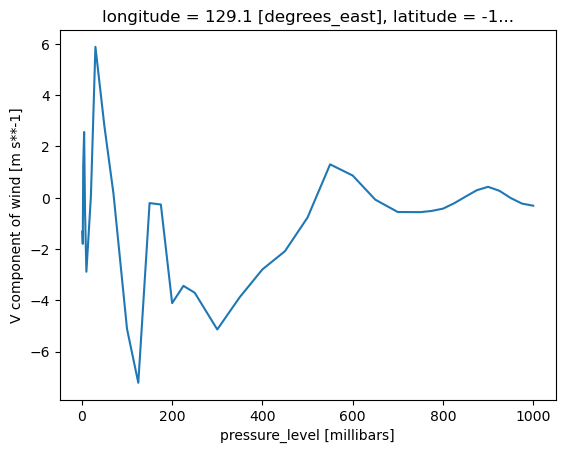

In [70]:
test = ds.interp(longitude=129.1244443, latitude=-11.43445, time=np.datetime64('2005-02-01T00:40:00'), method='linear')
test.load()['v'].plot()